In [135]:
import cartopy
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import numpy as np
import seaborn as sns
import reverse_geocoder as rg

plt.rcParams['figure.facecolor'] = "white"

## Plot pig location data

In [26]:
# Read in data and completed studies
dat = pd.read_csv("../data/formatted/full_pig_data.csv")
studies = [os.path.basename(s).split(".")[0] for s in glob.glob("../results/glmdata_by_study/*")]
tdat = dat[dat.study.isin(studies)]

/Users/mqwilber/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [95]:
# Get mean lat, lon by study
meanpoints = (tdat.groupby(['study', 'pigID'])
                 .agg({'latitude': np.mean, 'longitude': np.mean})
                 .reset_index())
import reverse_geocoder as rg

latlon = list(zip(meanpoints.latitude, meanpoints.longitude))
states = [a['admin1'] for a in rg.search(latlon)]
meanpoints['state'] = states
meanpoints.loc[(meanpoints.state == "Kansas") | (meanpoints.state == "Arkansas"), 'state'] = "Missouri"
meanpoints.loc[(meanpoints.state == "Mississippi"), 'state'] = "Louisiana"

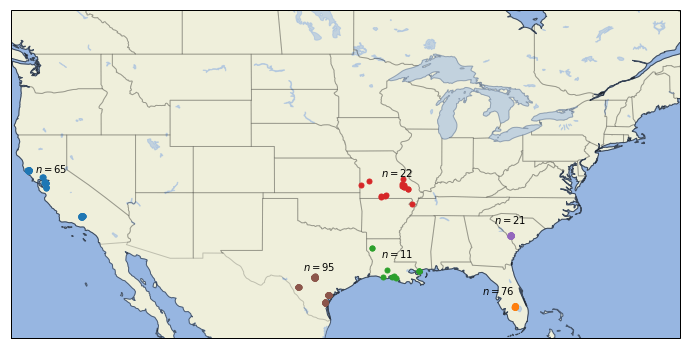

In [109]:
# Build map
fig = plt.figure(figsize=(12, 12))
crsPC = cartopy.crs.PlateCarree()
ax = plt.axes(projection=crsPC)

scale = "50m"
ax.add_feature(cartopy.feature.LAND.with_scale(scale))
ax.add_feature(cartopy.feature.OCEAN.with_scale(scale))
ax.add_feature(cartopy.feature.COASTLINE.with_scale(scale), alpha=0.5)
#ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES.with_scale(scale), alpha=0.5)
ax.add_feature(cartopy.feature.STATES.with_scale(scale), alpha=0.2)
ax.set_extent([-124.848974, -66.885444, 24.396308, 49.384358])

# Plot points
#ax.plot(meanpoints.longitude.values, meanpoints.latitude.values, 'o', color="red", ms=2, transform=crsPC)

# Plot sample size counts
statedat = (meanpoints.groupby("state").agg({'latitude': np.mean, 'longitude' : np.mean, 'pigID' : len})
                     .reset_index())
for state in statedat.state:
    
    ind = meanpoints.state == state
    ax.plot(meanpoints.longitude.values[ind], meanpoints.latitude.values[ind], 
                                            'o', ms=5, transform=crsPC)
    
    if state in ['Texas', 'California']:
        up = 1.5
    else:
        up = 1
    
    if state == 'Florida':
        ha = "right"
    else:
        ha = "center"
        
    ts = statedat[statedat.state == state]
    ax.text(ts.longitude, ts.latitude + up, "$n={0}$".format(ts.pigID.values[0]), ha=ha, transform=crsPC)


plt.show()

## Plot crop summary data

In [110]:
cropdat = pd.read_csv("../results/usedcrops_time.csv")

In [116]:
print("Number of unique crops used: " + str(len(cropdat.crop_name.unique())))
print("Number of pigs using crops: " + str(len(cropdat.pigID.unique())))

Number of unique crops used: 24
Number of pigs using crops: 159


In [125]:
statetable = (meanpoints.groupby("study")
                       .agg({'state' : lambda x: np.unique(x)[0]}))
cropdat_state = cropdat.set_index("study").join(statetable).reset_index()

Text(0,0.5,'Proportion of time in crop type')

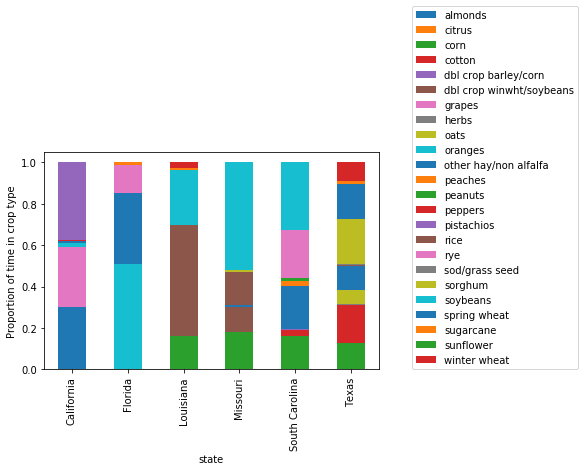

In [210]:
from matplotlib.colors import ListedColormap
cropsum = (cropdat_state.groupby(['state', "crop_name"]).agg({'hours': lambda x: np.log10(np.sum(x) + 1)})
             .reset_index())
props = cropsum.groupby(["state"]).apply(lambda x: x.hours / x.hours.sum())
cropsum['proportions'] = props.values
#cropsum
ax = (cropsum.pivot_table(values='proportions', index='state', columns='crop_name', fill_value=0)
       .plot(kind="bar", stacked=True))#, colormap=ListedColormap(sns.color_palette("Spectral", 24))))
ax.legend(loc=(1.1, 0))
ax.set_ylabel("Proportion of time in crop type")

In [205]:
sns.color_palette?

In [192]:
len(cropsum)

44

In [183]:
cropsum.groupby(["state"]).apply(lambda x: x.hours / x.hours.sum())

array([0.3027752 , 0.00055593, 0.28873736, 0.01924462, 0.00879716,
       0.00592787, 0.37396186, 0.00170612, 0.50585645, 0.34541811,
       0.13209503, 0.01492429, 0.16210306, 0.19126428, 0.34179354,
       0.26565422, 0.01347441, 0.02571049, 0.18118318, 0.12165634,
       0.00740881, 0.16040034, 0.00822083, 0.5211305 , 0.16257357,
       0.02733641, 0.00685667, 0.20620212, 0.0239088 , 0.01529012,
       0.23015887, 0.32767345, 0.12879051, 0.18163569, 0.00375956,
       0.06997125, 0.11728282, 0.00320227, 0.00470314, 0.21936997,
       0.16876317, 0.01150405, 0.00122618, 0.08979139])

In [144]:
cropdat_state.pivot_table?